In [6]:
# 导入相关库
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from minepy import MINE
from sklearn import svm
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn import naive_bayes
from scipy.stats import pearsonr
from sklearn.manifold import TSNE
from IPython.display import display
from datetime import datetime as dt
import joblib
from sklearn.decomposition import PCA
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score 

warnings.filterwarnings('ignore')
%matplotlib inline

In [7]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, X, y, cv=None, n_jobs=1):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure('Learning Curve', facecolor='lightgray')
    plt.title('Learning Curve')
    plt.xlabel('train size')
    plt.ylabel('score')
    plt.grid(linestyle=":")
    plt.plot(train_sizes, train_scores_mean, label='traning score')
    plt.plot(train_sizes, test_scores_mean, label='val score')
    plt.legend()
    plt.show()

select feature1 name: [2060 2064 3912]
select feature2 name: [ 77 247]
new_features shape: (39, 5)
训练集大小： (46, 5)
验证集大小： (8, 5)
测试集大小： (8, 5)


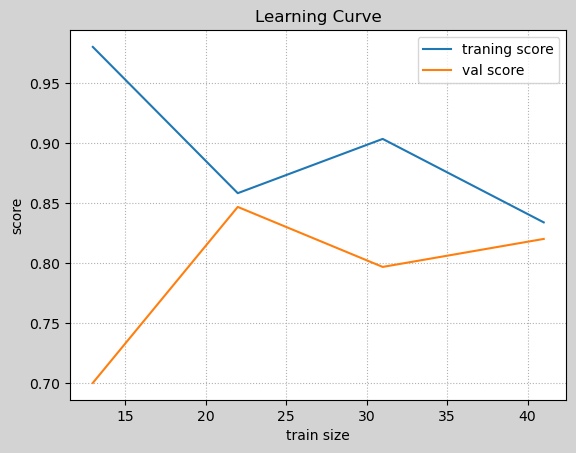

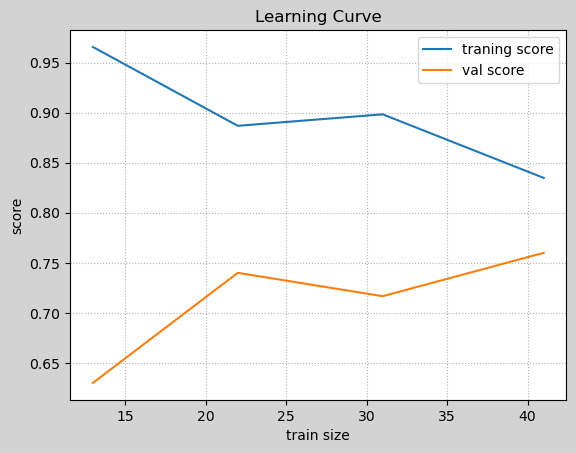

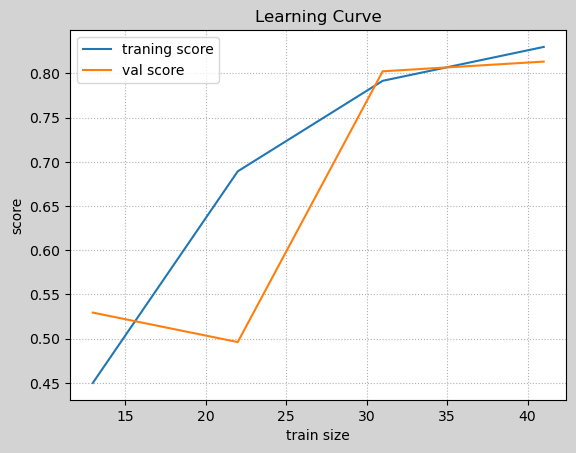

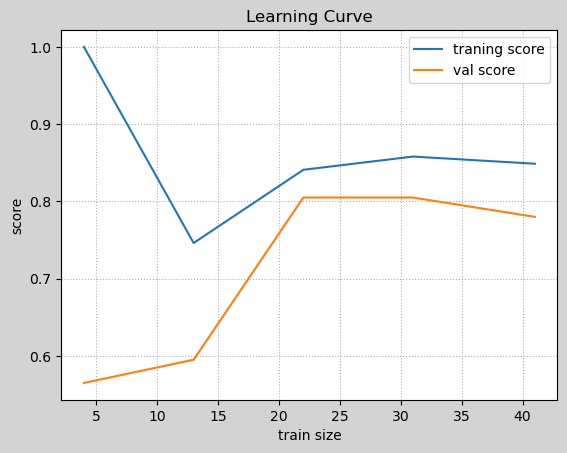

best_clf
------
VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1, multi_class='multinomial',
                                                 random_state=42,
                                                 solver='newton-cg')),
                             ('svc',
                              SVC(C=1, gamma=0.001, kernel='linear',
                                  max_iter=100, probability=True,
                                  random_state=42)),
                             ('gs', GaussianNB())],
                 voting='soft', weights=[1, 1, 2])

Unoptimized model
------
Accuracy score on validation data: 0.8750
Recall score on validation data: 1.0000
F-score on validation data: 0.8889

Optimized Model
------
Final accuracy score on the validation data: 0.8750
Recall score on validation data: 1.0000
Final F-score on the validation data: 0.8889
Accuracy on test data: 0.8750
Recall on test data: 0.6667
F-score on test data: 0.8000


In [9]:
def add_gaussian_noise(X, y, noise_stddev = 0.05):

    num_samples, num_features = X.shape
    noise = np.random.normal(loc=0.0, scale=noise_stddev, size=(num_samples, num_features))
    X_noisy = X + noise

    X_augmented = np.vstack((X, X_noisy))
    y_augmented = np.vstack((y, y))

    return X_augmented, y_augmented

def processing_data(data_path):

    feature1,feature2,label = None, None, None

    data_xls = pd.ExcelFile(data_path)
    data={}
    
    for name in data_xls.sheet_names:
            df = data_xls.parse(sheet_name=name,header=None)
            data[name] = df
    
    feature1_raw = data['Feature1']
    feature2_raw = data['Feature2']
    label = data['label']

    scaler = MinMaxScaler()
    feature1 = pd.DataFrame(scaler.fit_transform(feature1_raw))
    feature2 = pd.DataFrame(scaler.fit_transform(feature2_raw))
    
    return feature1,feature2,label

def feature_select(feature1, feature2, label): 

    select_feature_1_number = 3
    select_feature_2_number = 3
    select_feature1 = SelectKBest(lambda X, Y: tuple(map(tuple,np.array(list(map(lambda x:pearsonr(x, Y), X.T))).T)), 
                                  k=select_feature_1_number
                                 ).fit(feature1, np.array(label).flatten()).get_support(indices=True)

    select_feature2 = SelectKBest(lambda X, Y: tuple(map(tuple,np.array(list(map(lambda x:pearsonr(x, Y), X.T))).T)), 
                                  k=select_feature_2_number
                                 ).fit(feature2, np.array(label).flatten()).get_support(indices=True)

    print("select feature1 name:", select_feature1)
    print("select feature2 name:", select_feature2)
    new_features = pd.concat([feature1[feature1.columns.values[select_feature1]],
                              feature2[feature2.columns.values[select_feature2]]],axis=1)
    print("new_features shape:",new_features.shape)

    return new_features,label

def data_split(features,labels):

    X_train, X_val, X_test,y_train, y_val, y_test=None, None,None, None, None, None
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

    X_train, y_train = add_gaussian_noise(X_train, y_train)
    print("训练集大小：", X_train.shape)
    print("验证集大小：", X_val.shape)
    print("测试集大小：", X_test.shape)

    return X_train, X_val, X_test,y_train, y_val, y_test

def search_model(X_train, y_train,X_val,y_val, model_save_path):
    
    def model_and_train(model, parameters, X_train, y_train, scorer, kfold):
        grid_obj = GridSearchCV(estimator = model, param_grid = parameters, scoring = scorer, cv = kfold)
        plot_learning_curve(grid_obj, X_train, y_train, cv = kfold, n_jobs = 4)
        grid_obj.fit(X_train, y_train)
        best_clf = grid_obj.best_estimator_
        return best_clf
        return model
    
    scorer = make_scorer(fbeta_score, beta=1)
    kfold = KFold(n_splits = 10)

    # logistic regression
    lr = LogisticRegression(random_state = 42)
    parameters = {'C':[1, 10], 
                  'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'), 
                  'max_iter':[100, 1000], 
                  'multi_class':('ovr', 'multinomial')
                  }
    lr = model_and_train(lr, parameters, X_train, y_train, scorer, kfold)

    # support vector machine
    svc = svm.SVC(random_state = 42, probability = True)
    parameters = {'kernel':('linear', 'rbf'), 
                  'C':[1, 10], 
                  'gamma':[0.001, 0.0001], 
                  'max_iter':[100, 1000]}
    svc = model_and_train(svc, parameters, X_train, y_train, scorer, kfold)

    # gaussian naive bayes
    gs = naive_bayes.GaussianNB()
    parameters = {'var_smoothing':[1e-09, 1e-08, 1e-07, 1e-06, 1e-05]}
    gs = model_and_train(gs, parameters, X_train, y_train, scorer, kfold)

 
    voting_clf = VotingClassifier(estimators=[('lr', lr), 
                                              ('svc', svc),
                                              ('gs',gs)], 
                                              voting = 'soft')
    plot_learning_curve(voting_clf, X_train, y_train, cv=kfold, n_jobs=4)
    grid_obj = GridSearchCV(estimator = voting_clf, 
                            param_grid = {'weights':[[2,1,1], [1,2,1], [1,1,2]]}, 
                            scoring = scorer, cv = kfold)
    grid_obj.fit(X_train, y_train)
    best_clf = grid_obj.best_estimator_

    predictions = (voting_clf.fit(X_train, y_train)).predict(X_val)
    best_predictions = best_clf.predict(X_val)
    joblib.dump(best_clf, model_save_path)


    # Report the before-and-after scores
    print ("best_clf\n------")
    print (best_clf)

    print("\nUnoptimized model\n------")
    print("Accuracy score on validation data: {:.4f}".format(accuracy_score(y_val, predictions)))
    print("Recall score on validation data: {:.4f}".format(recall_score(y_val, predictions)))
    print("F-score on validation data: {:.4f}".format(fbeta_score(y_val, predictions, beta = 1)))
    print("\nOptimized Model\n------")
    print("Final accuracy score on the validation data: {:.4f}".format(accuracy_score(y_val, best_predictions)))
    print("Recall score on validation data: {:.4f}".format(recall_score(y_val, best_predictions)))
    print("Final F-score on the validation data: {:.4f}".format(fbeta_score(y_val, best_predictions, beta = 1)))

    
def load_and_model_prediction(X_test,y_test,save_model_path):
    
    my_model=joblib.load(save_model_path)

    copy_test = [value for value in X_test]
    copy_predicts = my_model.predict(X_test)

    print ("Accuracy on test data: {:.4f}".format(accuracy_score(y_test, copy_predicts)))
    print ("Recall on test data: {:.4f}".format(recall_score(y_test, copy_predicts)))
    print ("F-score on test data: {:.4f}".format(fbeta_score(y_test, copy_predicts, beta = 1)))

def main():

    data_path = "./DataSet.xlsx"
    save_model_path = './results/my_best_model.m'  

    feature1,feature2,label = processing_data(data_path)
    new_features,label = feature_select(feature1, feature2, label)
   
    X_train, X_val, X_test, y_train, y_val, y_test = data_split(new_features, label)
    
    search_model(X_train, y_train, X_val, y_val, save_model_path)
    load_and_model_prediction(X_test, y_test, save_model_path)


if __name__ == '__main__':
    main()